In [302]:
# Importing all the necessary libraries 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [303]:
# Finding the keys in the train and test .h5 file to name the label and feature

# Inspect the Train.h5 file
with h5py.File('dataset/Tr.h5', "r") as train_dataset:
    print("Train.h5 keys:", list(train_dataset.keys()))

# Inspect the Test.h5 file
with h5py.File('dataset/Te.h5', "r") as test_dataset:
    print("Test.h5 keys:", list(test_dataset.keys()))

Train.h5 keys: ['images', 'labels']
Test.h5 keys: ['images', 'labels']


In [304]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

def load_dataset():
    train_dataset = h5py.File('dataset/Tr.h5', "r")
    train_set_x_orig = np.array(train_dataset["images"][:])  # your train set features
    train_set_y_orig = np.array(train_dataset["labels"][:])  # your train set labels

    test_dataset = h5py.File('dataset/Te.h5', "r")
    test_set_x_orig = np.array(test_dataset["images"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["labels"][:])  # your test set labels

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig



In [305]:
# Using the loaded dataset 
train_x, train_y, test_x, test_y = load_dataset()


In [306]:
# Dimensions of the train and test dataset 
print(f"Training data shape: {train_x.shape}")
print(f"Training labels shape: {train_y.shape}")
print(f"Test data shape: {test_x.shape}")
print(f"Test labels shape: {test_y.shape}")

Training data shape: (250, 128, 128, 3)
Training labels shape: (250,)
Test data shape: (50, 128, 128, 3)
Test labels shape: (50,)


In [307]:
def preprocess_data(X, Y, num_classes):
    X = X / 255.0  # Normalize pixel values
    Y = np.eye(num_classes)[Y.reshape(-1)]  # One-hot encoding
    return X, Y

train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset()

# Preprocess the data
num_classes = 5
train_x, train_y = preprocess_data(train_set_x_orig, train_set_y_orig, num_classes)
test_x, test_y = preprocess_data(test_set_x_orig, test_set_y_orig, num_classes)

# Flatten the data
train_x = train_x.reshape(train_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T
train_y = train_y.reshape(train_y.shape[0], -1)
test_y = test_y.reshape(test_y.shape[0], -1)


In [308]:
print("Min and Max of X_train:", train_x.min(), train_x.max())
print("Min and Max of X_test:", test_x.min(), test_x.max())

Min and Max of X_train: 0.0 1.0
Min and Max of X_test: 0.0 1.0


In [309]:
# Dimensions of the train and test dataset 
print(f"Training data shape: {train_x.shape}")
print(f"Training labels shape: {train_y.shape}")
print(f"Test data shape: {test_x.shape}")
print(f"Test labels shape: {test_y.shape}")

Training data shape: (49152, 250)
Training labels shape: (250, 5)
Test data shape: (49152, 50)
Test labels shape: (50, 5)


In [310]:
# Initialize parameters for the network
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters


In [311]:
# Softmax activation for multi-class classification
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Stability improvement
    return expZ / np.sum(expZ, axis=0, keepdims=True)


In [312]:
# Forward propogation

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    return Z
     
def linear_activation_forward(A_prev, W, b, activation):
    Z = linear_forward(A_prev, W, b)
    if activation == "relu":
        A = np.maximum(0, Z)
    elif activation == "softmax":
        A = softmax(Z)
    return A, Z

def forward_propagation(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, Z = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append((A_prev, parameters['W' + str(l)], parameters['b' + str(l)], Z))
    
    AL, ZL = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    caches.append((A, parameters['W' + str(L)], parameters['b' + str(L)], ZL))
      
    return AL, caches
    

In [313]:
# Cost Function ( Cross Entropy )
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1/m * np.sum(Y * np.log(AL))
    return np.squeeze(cost)

In [314]:
def linear_backward(dZ, A_prev, W, b):
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    A_prev, W, b, Z = cache
    
    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    elif activation == "softmax":
        dZ = dA
    
    dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
    return dA_prev, dW, db

def backward_propagation(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    
    dAL = AL - Y
    
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "softmax")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+2)], current_cache, "relu")
        grads["dA" + str(l+1)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
    
    return grads

In [315]:
# Parameter updation 
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    
    return parameters

In [316]:
# Define the architecture (example 3 hidden layers)
layers_dims = [128 *128 * 3, 32, 8,5]

In [317]:
# Model training
def model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters(layers_dims)

    for i in range(num_iterations):
        # Forward propagation
        AL, caches = forward_propagation(X, parameters)
        
        # Compute cost
        cost = compute_cost(AL, Y)
        
        # Backward propagation
        grads = backward_propagation(AL, Y, caches)
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            costs.append(cost)
            print(f"Cost after iteration {i}: {cost}")

    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per hundreds)')
    plt.title(f"Learning rate = {learning_rate}")
    plt.show()

    return parameters

In [318]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(49152, 250)
(49152, 50)
(250, 5)
(50, 5)


Cost after iteration 0: 1.6094990845452193
Cost after iteration 100: 1.6093818799254325
Cost after iteration 200: 1.6092906216046896
Cost after iteration 300: 1.60915569754078
Cost after iteration 400: 1.6089196479693837
Cost after iteration 500: 1.6084352413686578
Cost after iteration 600: 1.6072270342555834
Cost after iteration 700: 1.6033242157286531
Cost after iteration 800: 1.5869577626021663
Cost after iteration 900: 1.5403265274439253
Cost after iteration 1000: 1.4803761189367817
Cost after iteration 1100: 1.3439250425457354
Cost after iteration 1200: 1.2720243273571257
Cost after iteration 1300: 1.1394547987726646
Cost after iteration 1400: 0.9233816777381415
Cost after iteration 1500: 0.6783120027147563
Cost after iteration 1600: 0.5297768818527508
Cost after iteration 1700: 0.4674534133951763
Cost after iteration 1800: 0.8664257429153065
Cost after iteration 1900: 0.19155359696321053


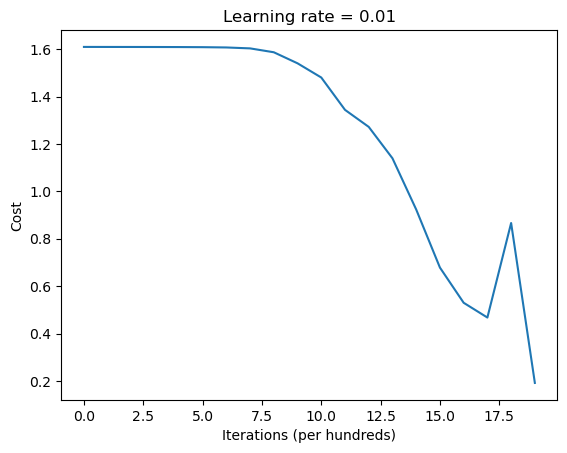

In [319]:
parameters = model(train_x, train_y.T, layers_dims,  learning_rate=0.01, num_iterations=2000, print_cost=True)


In [361]:
# Model predicion 
def predict(X, parameters):
    AL, _ = forward_propagation(X, parameters)
    print(f"AL shape: {AL.shape}") 
    predictions = np.argmax(AL, axis=0)

    return predictions

In [358]:
def predict(X, parameters):
    # Forward propagation to get predicted probabilities
    AL, _ = forward_propagation(X, parameters)  # AL should have shape (5, 50)
    
    # AL contains class probabilities, so no need to reshape or change AL here
    return AL

# Predictions on the test set
Y_pred = predict(test_x, parameters)  # Y_pred should have shape (5, 50)

# Print the shape to verify
print("AL shape:", Y_pred.shape)

# You should not need to preprocess Y_pred further unless you want to turn it into class indices or one-hot encoding.
# If you do want class predictions, you can convert them to one-hot encoding as follows:
Y_pred_class_indices = np.argmax(Y_pred, axis=0)  # This will give you a (50,) vector of predicted class indices
print("Class indices shape:", Y_pred_class_indices.shape)  # Output: (50,)

# If you need one-hot encoded predictions (shape (50, 5)):
Y_pred_one_hot = np.eye(5)[Y_pred_class_indices]  # This will give (50, 5), with one-hot encoded predictions
print("One-hot encoded predictions shape:", Y_pred_one_hot.shape)  # Output: (50, 5)

# If you want to transpose it back to (5, 50), you can do:
Y_pred_one_hot = Y_pred_one_hot.T
print("Transposed one-hot predictions shape:", Y_pred_one_hot.shape)  # Output: (5, 50)

AL shape: (5, 50)
Class indices shape: (50,)
One-hot encoded predictions shape: (50, 5)
Transposed one-hot predictions shape: (5, 50)


In [348]:
train_pred = predict(train_x, parameters)
test_pred = predict(test_x, parameters)

train_accuracy = np.mean(train_pred == np.argmax(train_y, axis=1)) * 100
test_accuracy = np.mean(test_pred == np.argmax(test_y, axis=1)) * 100

print(f"Train Accuracy: {train_accuracy}%")
print(f"Test Accuracy: {test_accuracy}%")

AL shape: (5, 250)
AL shape: (5, 50)
Train Accuracy: 99.2%
Test Accuracy: 44.0%


In [398]:
# Predictions on test set
Y_pred = predict(test_x, parameters)

Y_pred = np.eye(5)[Y_pred_class_indices]  # This will give (50, 5), with one-hot encoded predictions
Y_pred = Y_pred.T 
print("One-hot encoded predictions shape:", Y_pred.shape)





AL shape: (5, 50)
One-hot encoded predictions shape: (5, 50)


In [403]:
# Metrics: accuracy, precision, and recall
def compute_metrics(Y_pred, Y_true):
    accuracy = np.mean(Y_pred== Y_true)
    
    precision = np.sum((Y_pred == Y_true) & (Y_true == 1)) / np.sum(Y_pred == 1)
    recall = np.sum((Y_pred == Y_true) & (Y_true == 1)) / np.sum(Y_true == 1)
    
    return accuracy, precision, recall

In [404]:
print(Y_pred.shape)
print(test_y.shape)

(5, 50)
(50, 5)


In [405]:
# Compute metrics
accuracy, precision, recall = compute_metrics(Y_pred, test_y.T)

print(f"Accuracy: {accuracy * 100}%")
print(f"Precision: {precision * 100}%")
print(f"Recall: {recall * 100}%")

Accuracy: 77.60000000000001%
Precision: 44.0%
Recall: 44.0%
